# Ruby spectrum

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from modules import utils
import pandas as pd
import ast
import scipy as sp
from matplotlib import cm
from functools import partial
from typing import Literal

OUT_PATHS = {
    'figs_dir' : './figures',
    'results_dir' : './results',
}
IN_PATHS = {
    'black_body_dir' : './raw_data/Black_Body_Radiation',
    'na_dir' : './raw_data/Na_Spectrum',
    'ruby_dir' : './raw_data/Ruby_Spectrum',
    'laser_dir' : './raw_data/Laser_Spectrum',
}

# default figure settings
FIG_SIZE = np.array([6.4, 4]) # 16:10 aspect ratio
SAVE_FIG = True
FIG_FMT = 'pdf'
TRANSPARENT_PNG=True

# setting up stuff
savefig = partial(utils.save_fig, fig_dir=OUT_PATHS['figs_dir'], fig_fmt=FIG_FMT, fig_size=FIG_SIZE, save=SAVE_FIG, transparent_png=TRANSPARENT_PNG)
utils.check_paths(IN_PATHS, OUT_PATHS)

plt.close('all')

# style helpers
def fmtax(ax, label : bool | Literal['x', 'y'] = False, loc = 'upper left'):
    if label == True:
        ax.set_xlabel(r'wavelength [nm]')
        ax.set_ylabel(r'intensity [a.u.]')
    elif label == 'x':
        ax.set_xlabel(r'wavelength [nm]')
    elif label == 'y':
        ax.set_ylabel(r'intensity [a.u.]')
    ax.legend(loc=loc, frameon=False)
    ax.tick_params(direction='in', which='both')
    ax.minorticks_on()

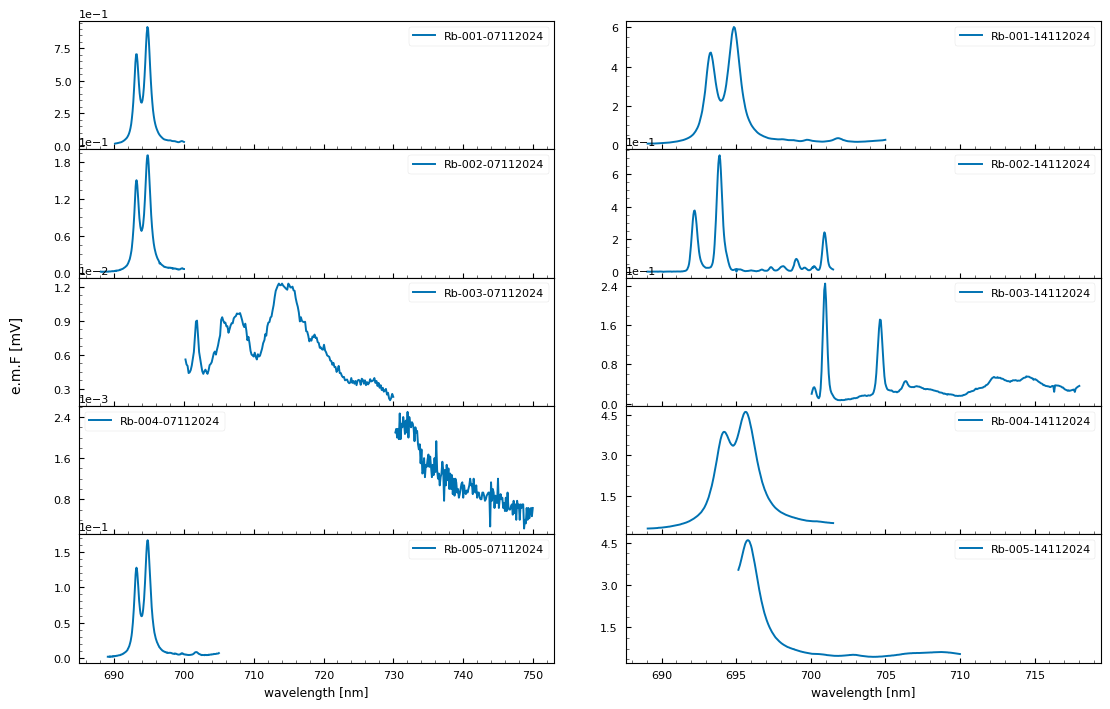

,type,id,date,integration time,PT tension,output slit,input slit,lock freq,temp,start,stop,step,samples
0,Rb,001,07112024,300ms,450V,2tac,2tac,307Hz,NaN,690.106018,700.0,0.100830,99
1,Rb,002,07112024,300ms,450V,1tac,1tac,307Hz,NaN,688.060242,700.0,0.060242,199
2,Rb,003,07112024,300ms,450V,1tac,1tac,307Hz,NaN,700.210510,730.0,0.150452,199
3,Rb,004,07112024,300ms,450V,1tac,1tac,307Hz,NaN,730.304565,750.0,0.124756,159
4,Rb,005,07112024,300ms,450V,1tac,1tac,307Hz,NaN,689.074158,705.0,0.064331,249
5,Rb,001,14112024,300ms,700V,2tac,2tac,307Hz,300K,689.064331,705.0,0.064087,249
6,Rb,002,14112024,300ms,700V,2tac,2tac,307Hz,77K,689.041687,701.5,0.041931,299
7,Rb,003,14112024,300ms,700V,2tac,2tac,307Hz,77K,700.060242,718.0,0.060059,299
8,Rb,004,14112024,300ms,700V,2tac,2tac,307Hz,4p7-5mV,689.071655,701.5,0.041748,299
9,Rb,005,14112024,300ms,700V,2tac,2tac,307Hz,5mV,695.149841,710.0,0.049866,299


In [3]:
from matplotlib.ticker import MaxNLocator

files = utils.getFiles('Raw_Data\\Ruby_Spectrum')
files = [file for file in files if file.name.find('Rb_') != -1]
df = pd.DataFrame([utils.file_to_series(file) for file in files])

# to nano meters
df['wl'] = df['wl'].apply(lambda x: x / 10)

# to mV
df['mean'] = df['mean'].apply(lambda x: x * 1000)

# sort it
df.sort_values('id', inplace=True)
df.sort_values('date', inplace=True)
df.reset_index(drop=True, inplace=True)

with plt.style.context(['seaborn-v0_8-colorblind', 'seaborn-v0_8-paper']):       
    # A quick look at the batch
    fig, axs = plt.subplots(5, 2, sharex='col', figsize = FIG_SIZE * 1.8)
    for i, row in df.iterrows():
        meta = ast.literal_eval(row['meta'])
        label = "-".join([meta.get(key) for key in ['type', 'id', 'date',]])
        axs[ i % 5, int(i / 5)].plot(row['wl'], row['mean'], label=label)
        
    for ax in axs.flat:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
        fmtax(ax, label='x', loc='upper right') 
        ax.yaxis.set_major_locator(MaxNLocator(4, prune='both'))
        ax.legend()
        
    # add common y label
    fig.text(0.04, 0.5, r'e.m.F [mV]', va='center', rotation='vertical')
    
    fig.tight_layout()
    fig.subplots_adjust(hspace=0, wspace=0.15, left=0.1)
    plt.show()
    savefig(fig, 'ruby_batch')
    
# generate the info table
info = df['meta'].apply(ast.literal_eval).apply(pd.Series)
info = info[['type', 'id', 'date'] + [col for col in info.columns if col not in ['type', 'id', 'date']]]
info['start'] = df['wl'].apply(lambda x: x[0])
info['stop'] = df['wl'].apply(lambda x: x[-1])
info['step'] = df['wl'].apply(lambda x: x[1] - x[0])
info['samples'] = df['wl'].apply(len)

info

In [30]:
from scipy.interpolate import interp1d

def mean_overlap(comm_wl : np.ndarray, batch : pd.DataFrame):
    ''' 
    This function computes the mean of varius slices of
    batch over an interval
    '''
    
    # this is the result
    mean = np.zeros(len(comm_wl))
    
    # this counts the number of samples 
    # in each wl
    counts = np.zeros(len(comm_wl))
    
    for i, row in batch.iterrows():
        wl = row['int_wl']
        y = row['int_mean']
        min = np.argmax(comm_wl >= wl.min())
        max = np.argmax(comm_wl > wl.max())
        
        # if the max is 0, it means that the wl is larger than the maximum
        if max == 0:
            max = len(comm_wl)

        mean[min:max]  =  mean[min:max] + y
        counts[min:max] = counts[min:max] + 1
    
    mean = np.divide(mean, counts, out=np.zeros_like(mean), where=counts!=0)
    return mean

def myinterp(series, x_new):
    # extract the x and y values
    x = series['wl']
    y = series['mean']
    
    # keep only the values that are within the range
    mask = np.logical_and(x_new > x.min(), x_new < x.max())
    x_new = x_new[mask]
    
    # return both the new x and the interpolated values
    f = interp1d(x, y, kind='linear')
    return x_new, f(x_new)

def interpolate_batch(batch, common_wl):
    ''' 
    If normalization is not given divide by the maximum value
    '''    
    # interpolate the batch
    batch['interp'] = batch.apply(myinterp, x_new = common_wl, axis=1).to_numpy()
    batch['int_wl'] = batch['interp'].apply(lambda x: x[0])
    batch['int_mean'] = batch['interp'].apply(lambda x: x[1])

    common_mean = mean_overlap(common_wl, batch)
    return common_mean

def plot_interp_batch(batch, common_wl, common_mean):
    with plt.style.context(['seaborn-v0_8-colorblind', 'seaborn-v0_8-paper']): 
        figsize = (FIG_SIZE[0] * 2, FIG_SIZE[1] * 1.5)
        fig, axs = plt.subplots(2, 1, figsize = figsize, sharex=True)
        # inset 
        inset = axs[0].inset_axes([0.48, 0.4, 0.5, 0.6])
        inset.set_xlim(698, 703)
        inset.set_ylim(0, .07)
        inset.set(yticks=[])
        
        # plot the mean
        axs[0].plot(common_wl, common_mean, label='mean', alpha = 0.7, zorder = 2)
        inset.plot(common_wl, common_mean, label='mean', alpha = 0.5, zorder = 2)
        

        # plot the interpolated batch
        batch.apply(lambda x: axs[0].plot(x['interp'][0], x['interp'][1], alpha=0.2, zorder = 1, label=x['id']), axis=1)
        batch.apply(lambda x: inset.plot(x['interp'][0], x['interp'][1], alpha=0.3, zorder = 1, label=x['id']), axis=1)

        # plot a clean result in log scale
        axs[1].plot(common_wl, common_mean, label='mean', alpha = 0.7, zorder = 2)
        axs[1].set_yscale('log')
        
        inset.legend(frameon=False)
        
        
        fig.tight_layout()
        fig.subplots_adjust(hspace=0)
        

        for ax in axs.flat:
            fmtax(ax, label='x', loc='upper left')
            ax.set_ylabel('intensity $[norm.]$')

        savefig(fig, 'ruby_spectrum_room_temperature', fig_size=figsize)
        plt.show()
        return axs

def normalize(series : pd.Series , ids : list, norm = None):
    if not (series['id'] in ids):
        return series
    
    if norm is None:
        norm = series['mean'].max()
   
    series['mean'] = series['mean'] / norm
    return series

def correct_sample(sample, responce):
    wl = sample['wl'].values[0]
    mean = np.array(sample['mean'].values[0])
    std = np.array(sample['std'].values[0])
    interp = interp1d(responce[0], responce[1], kind='linear')(wl)
    mean = mean * interp
    std = std * interp
    sample['mean'] = [mean]
    sample['std'] = [std]
    return sample


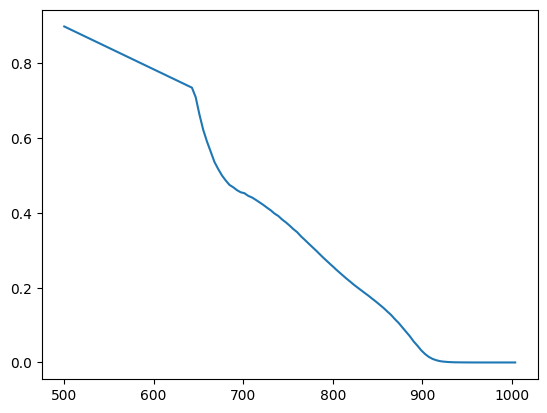

In [17]:
from scipy.interpolate import interp1d
responce = np.loadtxt(path.join(OUT_PATHS['results_dir'], 'responce.csv'), delimiter=',').T
plt.plot(responce[0], responce[1])
plt.show()

,type,id,date,integration time,PT tension,output slit,input slit,lock freq,temp,start,stop,step,samples
0,Rb,001,07112024,300ms,450V,2tac,2tac,307Hz,NaN,690.106018,700.0,0.100830,99
1,Rb,002,07112024,300ms,450V,1tac,1tac,307Hz,NaN,688.060242,700.0,0.060242,199
2,Rb,003,07112024,300ms,450V,1tac,1tac,307Hz,NaN,700.210510,730.0,0.150452,199
3,Rb,004,07112024,300ms,450V,1tac,1tac,307Hz,NaN,730.304565,750.0,0.124756,159
4,Rb,005,07112024,300ms,450V,1tac,1tac,307Hz,NaN,689.074158,705.0,0.064331,249


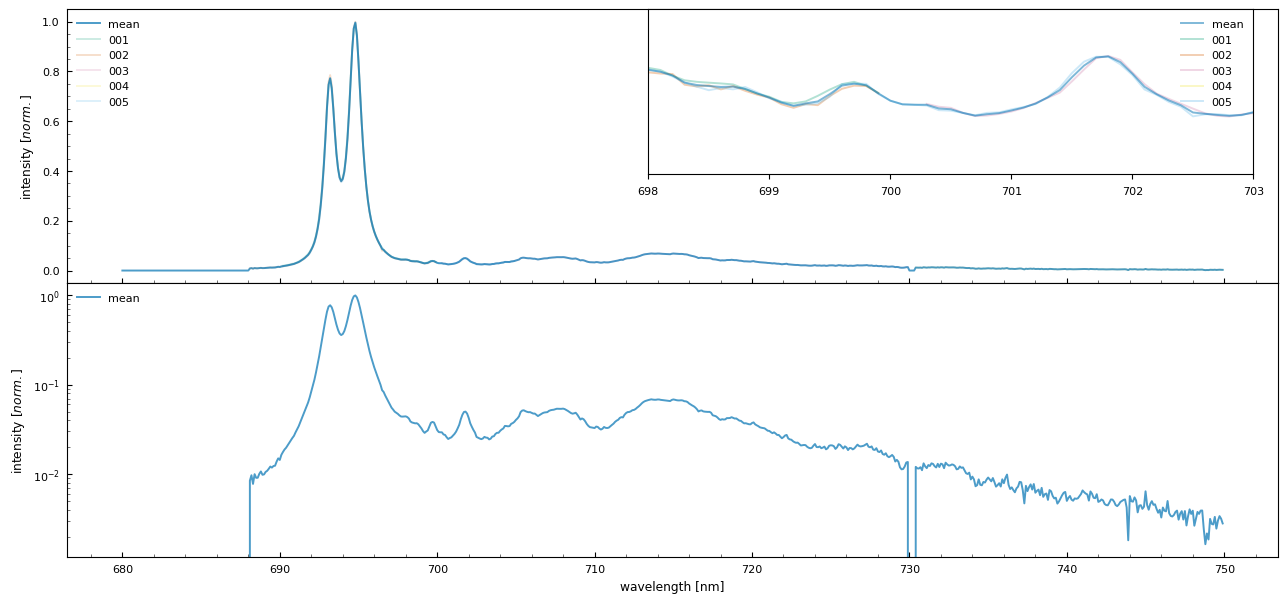

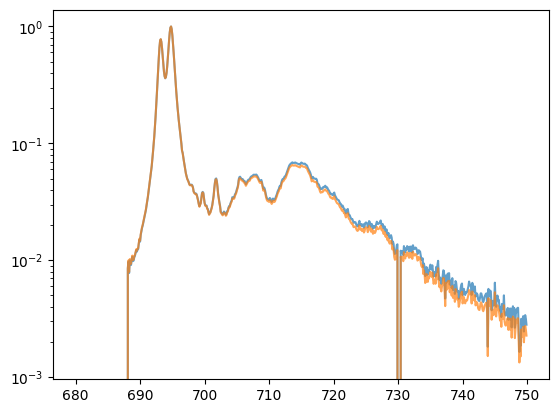

In [39]:
# @ room temperature
mask = df['date'] == '07112024' 
batch_0 = df[mask]
display(info[mask])
  
batch_0 = batch_0.apply(normalize, ids = ['001', '002', '005'] ,  axis=1)
batch_0 = batch_0.apply(normalize, ids = ['003', '004'] ,  axis=1, norm = 0.179)

common_wl_1711 = np.arange(680, 750, 0.1)
common_mean_1711 = interpolate_batch(batch_0, common_wl_1711)

axs = plot_interp_batch(batch_0, common_wl_1711, common_mean_1711)

interp = interp1d(responce[0], responce[1], kind='linear')(common_wl_1711)
corrected = common_mean_1711 * interp

plt.plot(common_wl_1711, common_mean_1711 / common_mean_1711.max(), label='corrected', alpha = 0.7, zorder = 2)
plt.plot(common_wl_1711, corrected / corrected.max(), label='corrected', alpha = 0.7, zorder = 2)
plt.yscale('log')
plt.show()

,type,id,date,integration time,PT tension,output slit,input slit,lock freq,temp,start,stop,step,samples
5,Rb,001,14112024,300ms,700V,2tac,2tac,307Hz,300K,689.064331,705.0,0.064087,249
6,Rb,002,14112024,300ms,700V,2tac,2tac,307Hz,77K,689.041687,701.5,0.041931,299
7,Rb,003,14112024,300ms,700V,2tac,2tac,307Hz,77K,700.060242,718.0,0.060059,299
8,Rb,004,14112024,300ms,700V,2tac,2tac,307Hz,4p7-5mV,689.071655,701.5,0.041748,299
9,Rb,005,14112024,300ms,700V,2tac,2tac,307Hz,5mV,695.149841,710.0,0.049866,299


C:\Users\alber\AppData\Local\Temp\ipykernel_10564\3571199338.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_0['temp'] = info.loc[mask, 'temp'].values
C:\Users\alber\AppData\Local\Temp\ipykernel_10564\3571199338.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_0['temp_groups'] = ['300K', '77K', '77K', '400K', '400K']
C:\Users\alber\AppData\Local\Temp\ipykernel_10564\3571199338.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

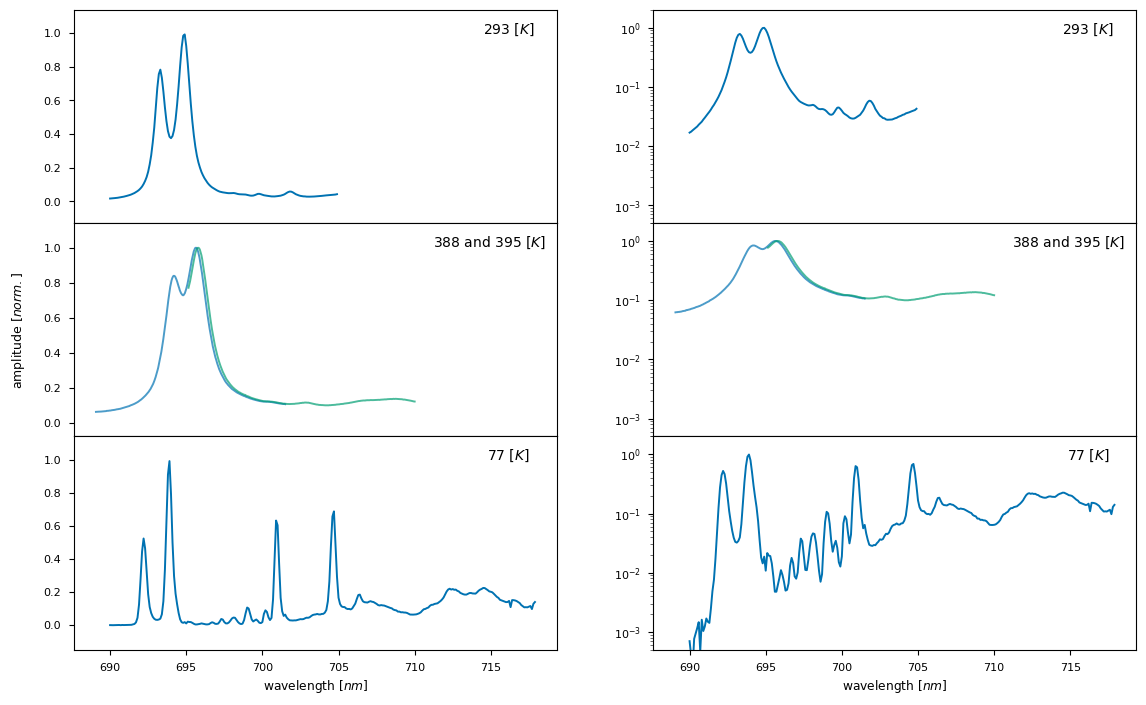

In [11]:
mask = df['date'] == '14112024' 
batch_0 = df[mask]
display(info[mask])

# add the temperature
batch_0['temp'] = info.loc[mask, 'temp'].values

# HACk
batch_0['temp_groups'] = ['300K', '77K', '77K', '400K', '400K']
batch_0['temp'] = ['300K', '77K', '77K', '390K', '400K']
ids = ['001', '002', '003', '004', '005']

common_wl = np.arange(690, 720, 0.1)
with plt.style.context(['seaborn-v0_8-colorblind', 'seaborn-v0_8-paper']):       
    fig, axs = plt.subplots(3, 2, figsize=FIG_SIZE * 2, sharex=True)
    i = 0
    for gid, group in batch_0.groupby('temp_groups'):
        # normalize the group
        group = group.apply(normalize, axis=1, ids = ids)

        # interpolate the group   
        fooone = lambda x: axs[i, 0].plot(x['wl'] , x['mean'], alpha=0.7)
        footwo = lambda x: axs[i, 1].plot(x['wl'] , x['mean'], alpha=0.7)
        if gid == '400K':
            group.apply(fooone, axis=1)
            group.apply(footwo, axis=1)
        else:
            common_mean = interpolate_batch(group, common_wl)
            # plot
            mask = common_mean > 0
            axs[i, 0].plot(common_wl[mask] , common_mean[mask])
            axs[i, 1].plot(common_wl[mask] , common_mean[mask])
            
        axs[i, 0].margins(y=0.15)
        axs[i, 1].set_ylim(5e-4, 2)
        axs[i, 1].set_yticks([1e-3, 1e-2, 1e-1, 1])
        axs[i, 1].margins(y=0.15)
        axs[i, 1].set_yscale('log')
        i = i + 1

    axs[0,0].set_title(r'$293\ [K]$', fontsize=10, y=0.85, x=0.9)
    axs[0,1].set_title(r'$293\ [K]$', fontsize=10, y=0.85, x=0.9)
    axs[1,0].set_title(r'$388$ and $395\ [K]$', fontsize=10, y=0.85, x=0.86)
    axs[1,1].set_title(r'$388$ and $395\ [K]$', fontsize=10, y=0.85, x=0.86)
    axs[2,0].set_title(r'$77\ [K]$', fontsize=10, y=0.85, x=0.9)
    axs[2,1].set_title(r'$77\ [K]$', fontsize=10, y=0.85, x=0.9)

    fig.subplots_adjust(hspace=0, left=0.07, right=0.9, top=0.9, bottom=0.1)
    fig.supylabel('amplitude $[norm.]$', fontsize=9)

    # common_mean = interpolate_batch(batch_0, common_wl)
    for ax in axs.flat:
        ax.set_xlabel('wavelength $[nm]$')
    savefig(fig, 'ruby_temp', fig_size=FIG_SIZE * 2)
    plt.show()